Satellite: Sentinel-1 <br>
Instrument: SAR-C <br>

Sensing Date: 2017-06-02T03:04:13.563Z <br>
Sensing Date: 2017-07-08T03:04:15.560Z <br>
Sensing Date: 2017-08-13T03:04:17.691Z <br>

<img src='sources/kazan.png'>

# Part I. Working on the Subset Near Kazan (1)

In [1]:
import rasterio
import pandas as pd
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## Load the Data

In [3]:
# load training dataset
ship_positives = pd.read_json('../sar_ship_dataset/json/ship_positives.json')
false_positives = pd.read_json('../sar_ship_dataset/json/false_positives.json')

In [5]:
# preprocess positive class samples
ship_positives_patches = []
ship_positives_windows = []

for ind in tqdm(ship_positives):
    patch = np.array(ship_positives[ind][0]['patchfu'])
    window = np.array(ship_positives[ind][0]['windowfu'])
    
    patch[patch<0.001] = 0.001
    window[window<0.001] = 0.001
    patch = 10*np.log10(patch)
    window = 10*np.log10(window)
    
    ship_positives_patches.append(patch[50-25:50+26, 50-25:50+26])
    ship_positives_windows.append(window)

1596it [00:00, 2254.48it/s]          


In [6]:
# preprocess negative class samples
false_positives_patches = []
false_positives_windows = []

for ind in tqdm(false_positives):
    patch = np.array(false_positives[ind][0]['patchfu'])
    window = np.array(false_positives[ind][0]['windowfu'])
    
    patch[patch<0.001] = 0.001
    window[window<0.001] = 0.001
    patch = 10*np.log10(patch)
    window = 10*np.log10(window)
    
    false_positives_patches.append(patch)
    false_positives_windows.append(window)

6384it [00:01, 5491.70it/s]          


In [9]:
print('Positive class size:', len(ship_positives_patches))
print('Negative class size:', len(false_positives_patches))

Positive class size: 1596
Negative class size: 6384


In [2]:
# load SAR image
kazan = rasterio.open('../data/images/kazan/kazan_3.tif')
kazan = kazan.read()
kazan = kazan[0]

In [7]:
kazan[kazan<0.001] = 0.001
kazan = 10*np.log10(kazan)

In [8]:
# load coordinates of the detected in SNAP objects
detected_objects = pd.read_csv('../data/sar/kazan/subset_kazan_Orb_Cal_THR_SHP.data/vector_data/ShipDetections.csv',
                               header=None, sep='\t', usecols=[2,3,4,5], skiprows=[0,1,2,3,4])

In [9]:
detected_objects.head()

,2,3,4,5
0,447,823,55.785611,49.093836
1,430,909,55.777651,49.093755
2,1013,821,55.795370,49.005195
3,1009,863,55.791500,49.004593
4,830,925,55.782989,49.030727


In [14]:
# crop the detected objects
detected_objects_patches = []
detected_objects_windows = []

for detected_object in detected_objects.iterrows():
    detected_objects_patches.append(kazan[int(detected_object[1][3])-25:int(detected_object[1][3])+26,
                   int(detected_object[1][2])-25:int(detected_object[1][2])+26])
    detected_objects_windows.append(kazan[int(detected_object[1][3])-10:int(detected_object[1][3])+11,
                      int(detected_object[1][2])-10:int(detected_object[1][2])+11])

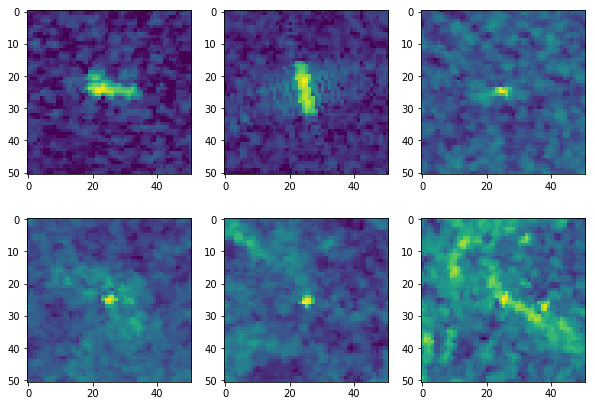

In [178]:
# plot examples of the training samples
plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(ship_positives_patches[4])
plt.subplot(232)
plt.imshow(ship_positives_patches[224])
plt.subplot(233)
plt.imshow(ship_positives_patches[1114])
plt.subplot(234)
plt.imshow(false_positives_patches[4])
plt.subplot(235)
plt.imshow(false_positives_patches[224])
plt.subplot(236)
plt.imshow(false_positives_patches[1114])
plt.show()
#plt.savefig('dataset')

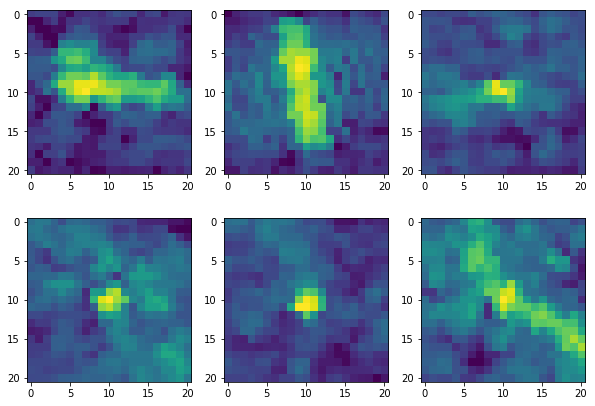

In [10]:
# plot examples of the zoomed training samples
plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(ship_positives_windows[4])
plt.subplot(232)
plt.imshow(ship_positives_windows[224])
plt.subplot(233)
plt.imshow(ship_positives_windows[1114])
plt.subplot(234)
plt.imshow(false_positives_windows[4])
plt.subplot(235)
plt.imshow(false_positives_windows[224])
plt.subplot(236)
plt.imshow(false_positives_windows[1114])
plt.show()

In [12]:
rand_pics = np.random.choice(range(len(detected_objects)), size=6)

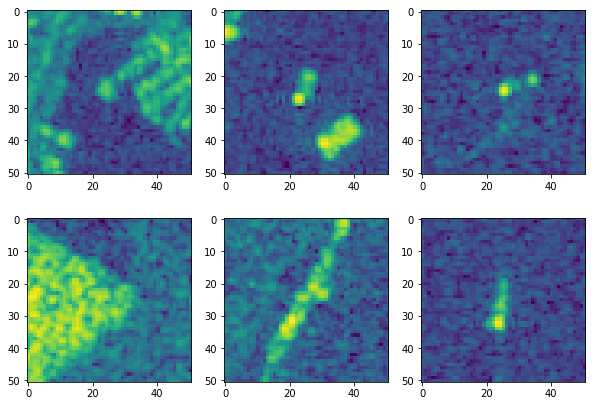

In [13]:
# plot random examples of the detected objects
plt.figure(figsize=(10,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(detected_objects_patches[rand_pics[i]])
plt.show()

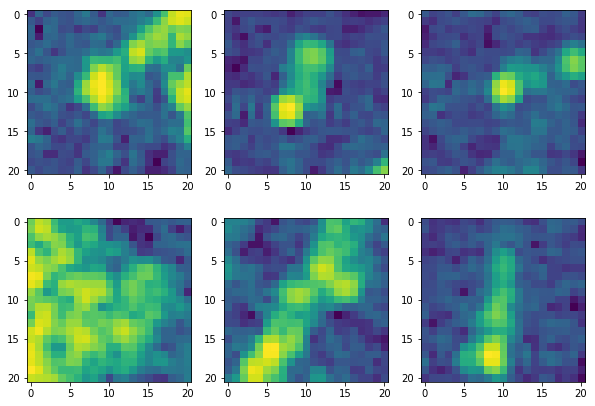

In [14]:
# plot random examples of the zoomed detected objects
plt.figure(figsize=(10,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(detected_objects_windows[rand_pics[i]])
plt.show()

## Train the Neurak Network

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = np.concatenate((ship_positives_patches, false_positives_patches))
print(X.shape)

(7980, 51, 51)


In [13]:
X = X.reshape(7980,51,51,1)
print(X.shape)

(7980, 51, 51, 1)


In [14]:
y = np.concatenate(([1]*len(ship_positives_windows), [0]*len(false_positives_windows)))

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

/Users/vasilii/.virtualenvs/research/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
#Building the model
gmodel=Sequential()
#Conv Layer 1
gmodel.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(51, 51, 1)))
gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
gmodel.add(Dropout(0.2))

#Conv Layer 2
gmodel.add(Conv2D(64, kernel_size=(2, 2), activation='relu' ))
gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
gmodel.add(Dropout(0.2))

#Conv Layer 3
gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
gmodel.add(Dropout(0.2))

#Conv Layer 4
gmodel.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
gmodel.add(Dropout(0.2))

#Flatten the data for upcoming dense layers
gmodel.add(Flatten())

#Dense Layer 1
gmodel.add(Dense(256))
gmodel.add(Activation('relu'))
gmodel.add(Dropout(0.2))

#Dense Layer 2
gmodel.add(Dense(128))
gmodel.add(Activation('relu'))
gmodel.add(Dropout(0.2))

#Sigmoid Layer
gmodel.add(Dense(1))
gmodel.add(Activation('sigmoid'))

mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
gmodel.compile(loss='binary_crossentropy', optimizer=mypotim, metrics=['accuracy'])
gmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 49, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
__________

In [18]:
es = EarlyStopping('val_loss', patience=10, mode="min")
msave = ModelCheckpoint('.model_weights.hdf5', save_best_only=True)
callbacks = [es, msave]

In [20]:
gmodel.fit(X_train, y_train, batch_size=24, epochs=50, verbose=1, validation_data=(X_valid, y_valid),
           callbacks=callbacks)

Train on 6384 samples, validate on 1596 samples
Epoch 1/50
6384/6384 [==============================] - 23s 4ms/step - loss: 0.0649 - acc: 0.9779 - val_loss: 0.0944 - val_acc: 0.9649
Epoch 2/50
6384/6384 [==============================] - 22s 3ms/step - loss: 0.0700 - acc: 0.9740 - val_loss: 0.0743 - val_acc: 0.9706
Epoch 3/50
6384/6384 [==============================] - 27s 4ms/step - loss: 0.0643 - acc: 0.9759 - val_loss: 0.0782 - val_acc: 0.9718
Epoch 4/50
6384/6384 [==============================] - 24s 4ms/step - loss: 0.0583 - acc: 0.9829 - val_loss: 0.1217 - val_acc: 0.9599
Epoch 5/50
6384/6384 [==============================] - 22s 4ms/step - loss: 0.0674 - acc: 0.9754 - val_loss: 0.0900 - val_acc: 0.9655
Epoch 6/50
6384/6384 [==============================] - 23s 4ms/step - loss: 0.0676 - acc: 0.9746 - val_loss: 0.0834 - val_acc: 0.9680
Epoch 7/50
6384/6384 [==============================] - 23s 4ms/step - loss: 0.0621 - acc: 0.9785 - val_loss: 0.0873 - val_acc: 0.9687
Epoch 8

## Make Predictions

In [12]:
gmodel.load_weights(filepath='.model_weights.hdf5')

In [15]:
test = np.array(detected_objects_patches).reshape(63,51,51,1)

In [16]:
predicted = gmodel.predict(test, verbose=1)
predicted = np.array([i[0] for i in predicted])

63/63 [==============================] - 0s 2ms/step


In [156]:
pr_s = predicted.argsort()

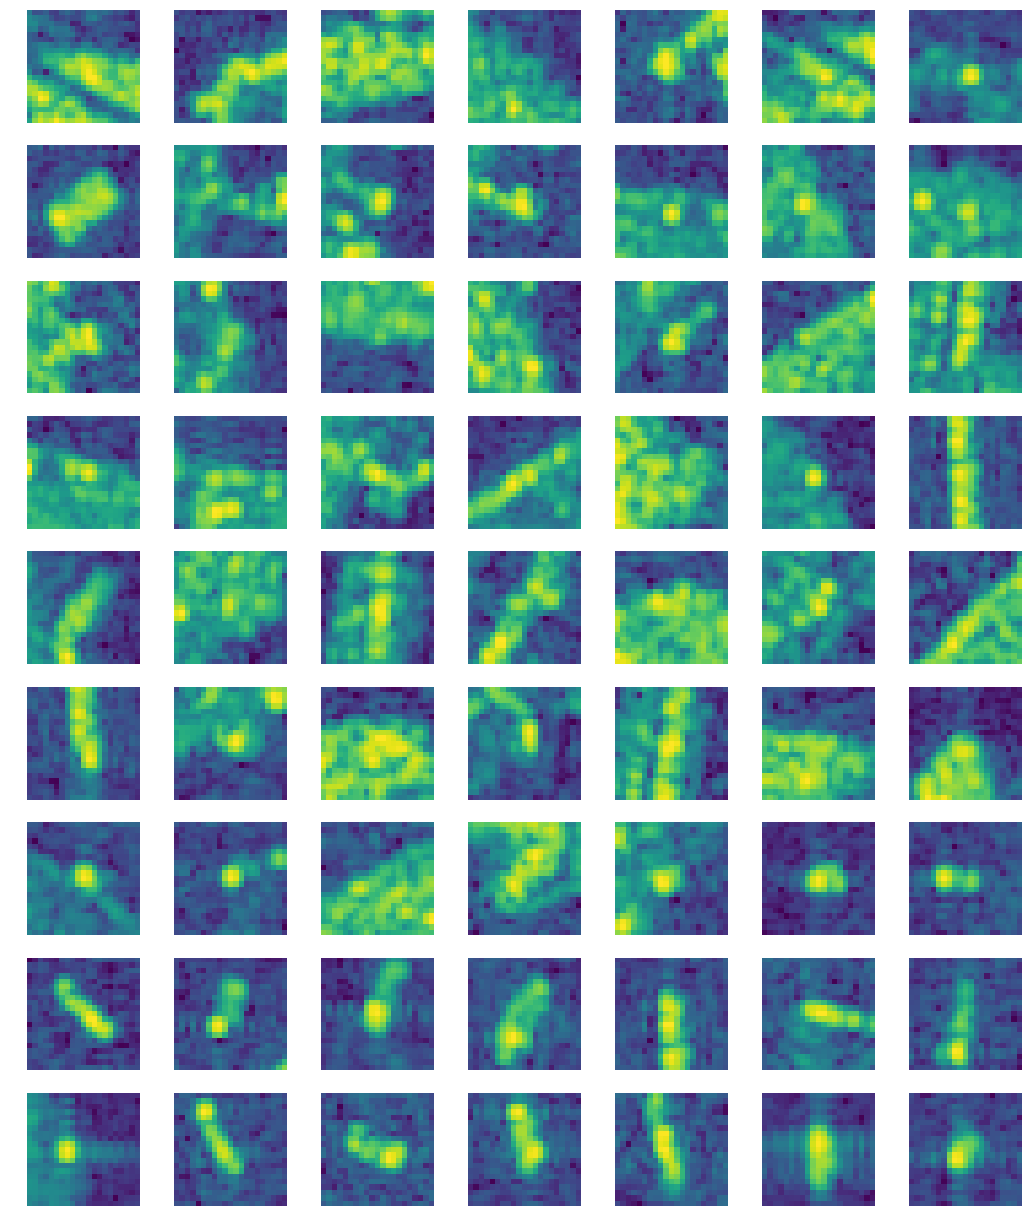

In [157]:
# plot the zoomed objects (from less probable to more probable ships)
plt.figure(figsize=(18,22))
for i in range(63):
    plt.subplot(9,7,i+1)
    plt.axis('off')
    plt.imshow(detected_objects_windows[pr_s[i]])
plt.show()

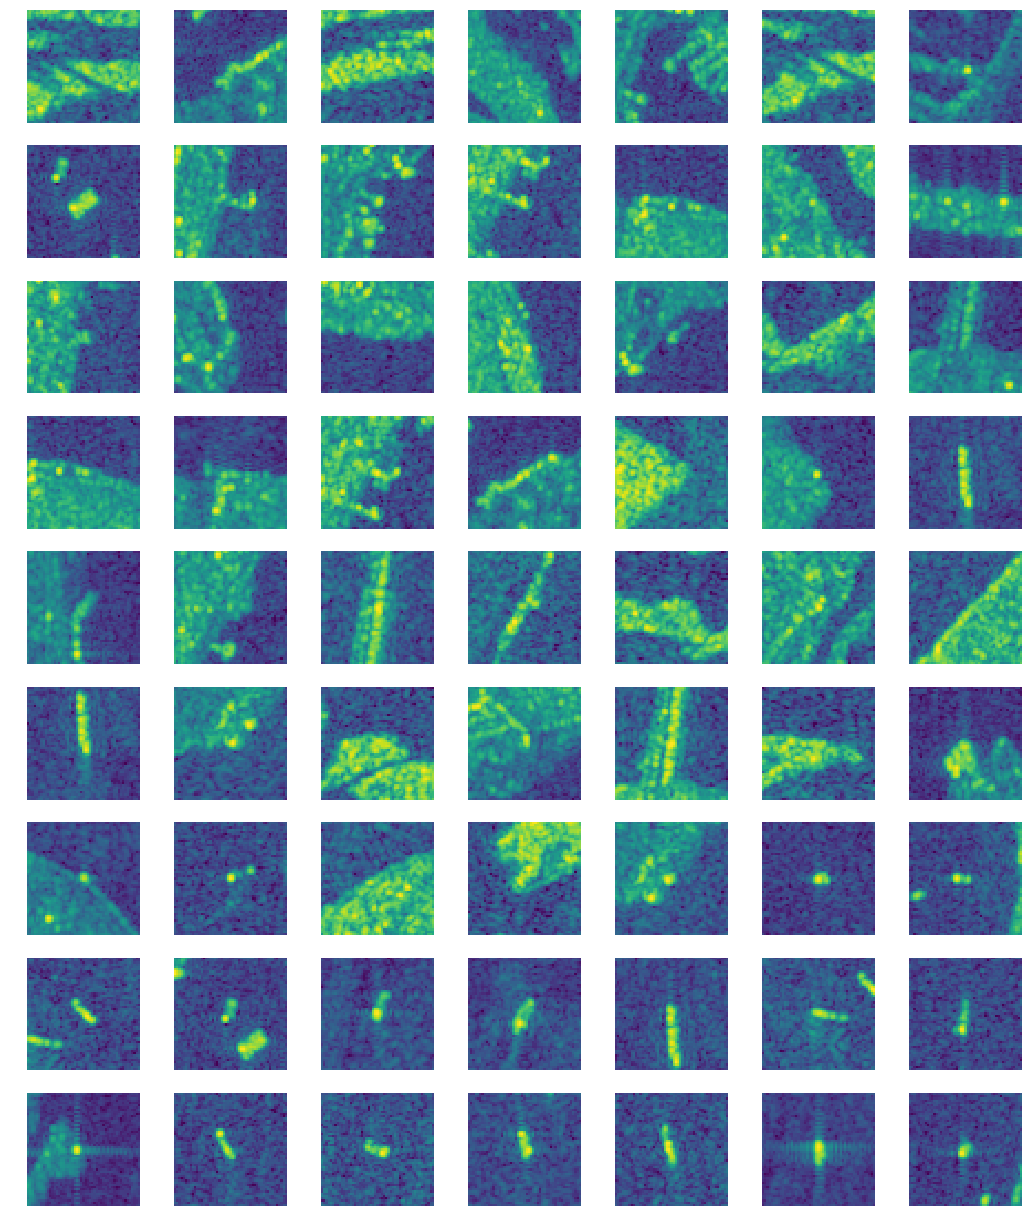

In [158]:
# plot the objects (from less probable to more probable ships)
plt.figure(figsize=(18,22))
for i in range(63):
    plt.subplot(9,7,i+1)
    plt.axis('off')
    plt.imshow(detected_objects_patches[pr_s[i]])
plt.show()

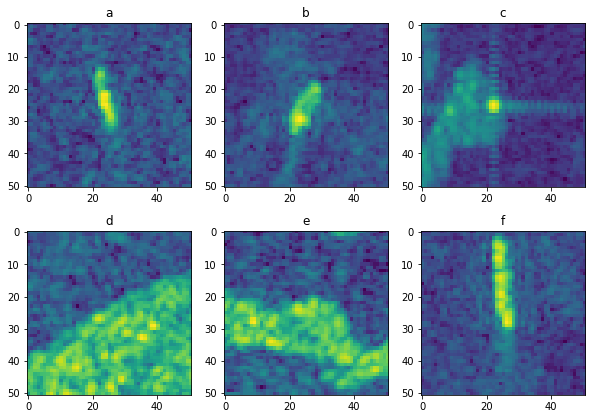

In [205]:
# plot examples of right and wrong classified objects
plt.figure(figsize=(10,7))
plt.subplot(231)
plt.title('a')
plt.imshow(detected_objects_patches[pr_s[60]])
plt.subplot(232)
plt.title('b')
plt.imshow(detected_objects_patches[pr_s[52]])
plt.subplot(233)
plt.title('c')
plt.imshow(detected_objects_patches[pr_s[56]])
plt.subplot(234)
plt.title('d')
plt.imshow(detected_objects_patches[pr_s[44]])
plt.subplot(235)
plt.title('e')
plt.imshow(detected_objects_patches[pr_s[32]])
plt.subplot(236)
plt.title('f')
plt.imshow(detected_objects_patches[pr_s[35]])
# plt.savefig('detected')

In [17]:
ships_jun = detected_objects.iloc[np.where(predicted>0.5)][[4,5]]

# Part II. Workin with Two Broad Regions (2, 3)

In [19]:
kazan = rasterio.open('../data/images/kazan/kazan_jul.tif')
kazan = kazan.read()
kazan = kazan[0]

In [22]:
kazan = np.array(kazan, float)

In [24]:
kazan[kazan<0.001] = 0.001
kazan = 10*np.log10(kazan)

In [25]:
detected_objects = pd.read_csv('../data/sar/kazan/kazan_jul_orb_Cal_THR_SHP.data/vector_data/ShipDetections.csv',
                               header=None, sep='\t', usecols=[3,4,5,6], skiprows=[0,1,2,3,4])

In [26]:
detected_objects.head()

,3,4,5,6
0,20739,1427,56.710470,47.260894
1,23074,1368,56.748901,46.885801
2,23091,1385,56.747672,46.882544
3,19101,4431,56.418108,47.442131
4,19080,4481,56.413322,47.444201


In [27]:
print('Objects detected:', len(detected_objects))

Objects detected: 459


In [28]:
detected_objects_patches = []

for detected_object in detected_objects.iterrows():
    detected_objects_patches.append(kazan[int(detected_object[1][4])-25:int(detected_object[1][4])+26,
                   int(detected_object[1][3])-25:int(detected_object[1][3])+26])

In [199]:
rand_pics = np.random.choice(range(len(detected_objects)), size=6)

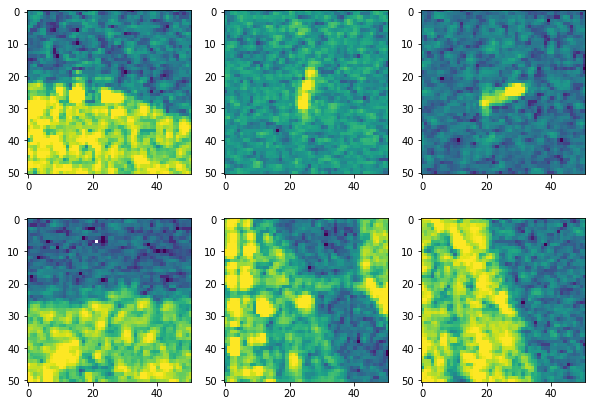

In [200]:
plt.figure(figsize=(10,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.array(detected_objects_patches[rand_pics[i]], float))
plt.show()

In [29]:
test = np.array(detected_objects_patches).reshape(459,51,51,1)

In [30]:
predicted = gmodel.predict(test, verbose=1)
predicted = np.array([i[0] for i in predicted])

459/459 [==============================] - 0s 994us/step


In [35]:
ships_jul = detected_objects.iloc[np.where(predicted>0.5)[0]][[5,6]]

In [36]:
print('Classified ships:', len(ships_jul))

Classified ships: 55


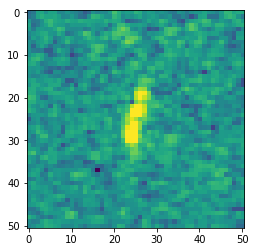

In [124]:
plt.imshow(np.array(detected_objects_patches[175], float))

In [39]:
kazan = rasterio.open('../data/images/kazan/kazan_aug.tif')
kazan = kazan.read()
kazan = kazan[0]

kazan = np.array(kazan, float)

kazan[kazan<0.001] = 0.001
kazan = 10*np.log10(kazan)

In [40]:
kazan.shape

(19396, 26080)

In [41]:
detected_objects = pd.read_csv('../data/sar/kazan/kazan_aug_orb_Cal_THR_SHP.data/vector_data/ShipDetections.csv',
                               header=None, sep='\t', usecols=[2,3,4,5], skiprows=[0,1,2,3,4])

In [42]:
print('Objects detected:', len(detected_objects))

Objects detected: 440


In [43]:
detected_objects.head()

,2,3,4,5
0,12398,4710,56.289719,48.503546
1,21216,4898,56.407299,47.092758
2,21213,4905,56.406675,47.093065
3,20722,5301,56.364240,47.160993
4,24223,5279,56.415464,46.601722


In [44]:
detected_objects_patches = []

for detected_object in detected_objects.iterrows():
    detected_objects_patches.append(kazan[int(detected_object[1][3])-25:int(detected_object[1][3])+26,
                   int(detected_object[1][2])-25:int(detected_object[1][2])+26])

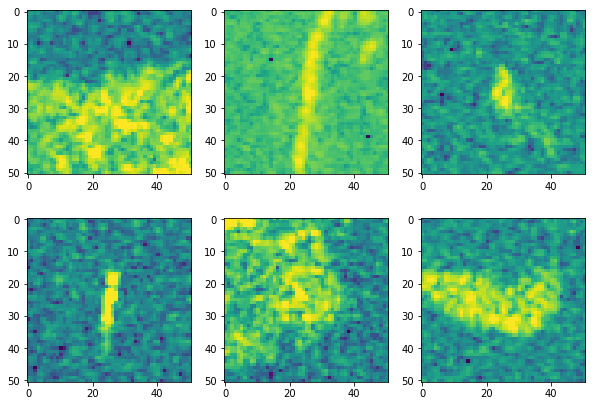

In [322]:
rand_pics = np.random.choice(range(len(detected_objects)), size=6)

plt.figure(figsize=(10,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.array(detected_objects_patches[rand_pics[i]], float))
plt.show()

In [45]:
test = np.array(detected_objects_patches).reshape(440,51,51,1)

In [46]:
predicted = gmodel.predict(test, verbose=1)
predicted = np.array([i[0] for i in predicted])

440/440 [==============================] - 0s 939us/step


In [47]:
ships_aug = detected_objects.iloc[np.where(predicted>0.5)[0]][[4,5]]

In [48]:
print('Classified ships:', len(ships_aug))

Classified ships: 59


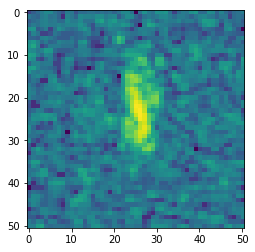

In [334]:
plt.imshow(np.array(detected_objects_patches[46], float))

# Part III. Geovisualization of the Detected Objects Classified as Ships

In [51]:
import folium

In [156]:
ships_map = folium.Map((ships_jun.loc[3][4], ships_jun.loc[3][5]), zoom_start=7)

for ship in ships_jun.iterrows():
    folium.Circle(radius=100, location=[ship[1][4], ship[1][5]], color='crimson', fill=True).add_to(ships_map)
    
for ship in ships_jul.iterrows():
    folium.Circle(radius=100, location=[ship[1][5], ship[1][6]], color='green', fill=True).add_to(ships_map)
    
for ship in ships_aug.iterrows():
    folium.Circle(radius=100, location=[ship[1][4], ship[1][5]], color='blue', fill=True).add_to(ships_map)

In [158]:
ships_map

<img src='sources/ships.png'>

In [136]:
# find stationary_ships
ships_jul_r = ships_jul.round(3)
ships_aug_r = ships_aug.round(3)

ships_aug_r.columns = ['latitude', 'longitude']
ships_jul_r.columns = ['latitude', 'longitude']

stationary_ships = pd.merge(ships_aug_r, ships_jul_r, on=['latitude', 'longitude'])

In [137]:
print('Number of stationary ships:', len(stationary_ships))

Number of stationary ships: 10


In [222]:
from math import *


def deg_min_sec(degrees = 0.0):
    if type(degrees) != 'float':
        try:
            degrees = float(degrees)
        except:
            print('\nERROR: Could not convert %s to float.' %(type(degrees)))
            return 0
    minutes = degrees%1.0*60
    seconds = minutes%1.0*60
    
    return '%s %s %s' %(int(floor(degrees)), int(floor(minutes)), int(seconds))

In [223]:
for ship in stationary_ships.iterrows():
    print('Latitude:', deg_min_sec(ship[1]['latitude']), '\tLongitude:', deg_min_sec(ship[1]['longitude']))

Latitude: 56 10 12 	Longitude: 47 16 37
Latitude: 56 12 57 	Longitude: 46 53 34
Latitude: 55 47 27 	Longitude: 49 0 18
Latitude: 55 49 22 	Longitude: 48 40 4
Latitude: 55 47 34 	Longitude: 48 43 58
Latitude: 55 46 26 	Longitude: 48 40 8
Latitude: 55 21 3 	Longitude: 49 26 13
Latitude: 55 5 6 	Longitude: 49 21 46
Latitude: 55 4 26 	Longitude: 49 14 13
Latitude: 55 2 27 	Longitude: 49 0 43


In [280]:
stationary_ships_map = folium.Map((ships_jun.loc[3][4], ships_jun.loc[3][5]), zoom_start=8)
    
for ship in stationary_ships.iterrows():
    text = 'Latitude: ' + deg_min_sec(ship[1]['latitude']) + ' | Longitude: ' + deg_min_sec(ship[1]['longitude'])
    folium.Circle(radius=200, location=[ship[1]['latitude'], ship[1]['longitude']], 
                  color='black', fill=True, popup=text).add_to(stationary_ships_map)

In [281]:
stationary_ships_map

<img src='sources/stationary.png'>

In [283]:
map1 = plt.imread('sources/map1.png')
map2 = plt.imread('sources/map2.png')
jul1 = plt.imread('sources/jul1.png')
jul2 = plt.imread('sources/jul2.png')
aug1 = plt.imread('sources/aug1.png')
aug2 = plt.imread('sources/aug2.png')

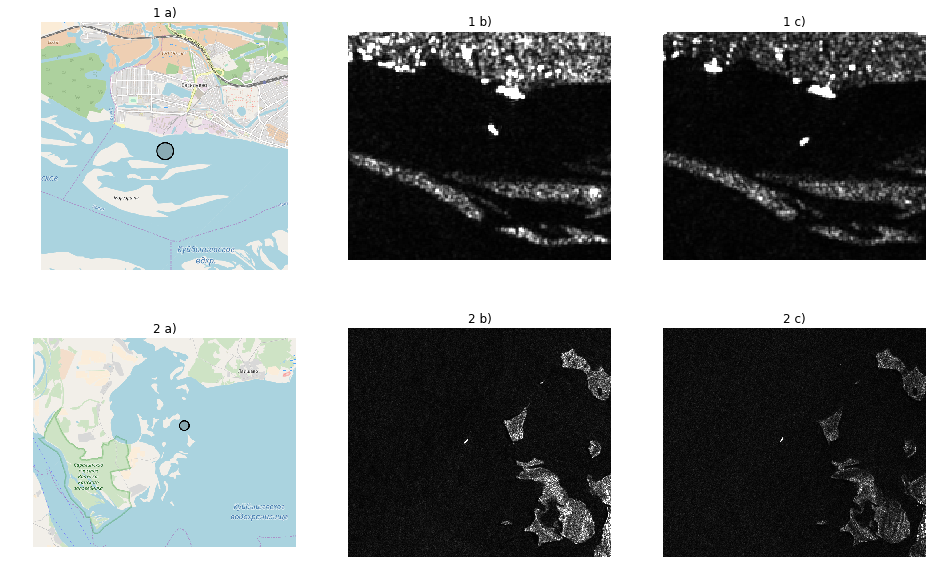

In [285]:
plt.figure(figsize=(16,10))
plt.subplot(231)
plt.imshow(map1)
plt.title('1 a)')
plt.axis('off')
plt.subplot(232)
plt.imshow(jul1)
plt.title('1 b)')
plt.axis('off')
plt.subplot(233)
plt.imshow(aug1)
plt.title('1 c)')
plt.axis('off')
plt.subplot(234)
plt.imshow(map2)
plt.title('2 a)')
plt.axis('off')
plt.subplot(235)
plt.imshow(jul2)
plt.title('2 b)')
plt.axis('off')
plt.subplot(236)
plt.imshow(aug2)
plt.title('2 c)')
plt.axis('off')
#plt.savefig('stationary_example.png')
plt.show()